In [1]:
dataset = '/Users/jproza/Google Drive/dataset'
ejemplos = '/Users/jproza/Google Drive/ejemplos'
    
import numpy as np
import os
from imageio import imread,imwrite
import matplotlib.pyplot as plt 

np.random.seed(5)

from keras.models import Sequential,Model
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Input
from keras.layers.core import Activation
from keras.optimizers import Adam
#import tensorflow as tf


Using TensorFlow backend.
/Users/jproza/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jproza/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jproza/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jproza/opt/anaconda3/lib/python3.7

In [5]:
def cargar_Data_Set():
    print('cargando el dataset inicial')
    filelst = os.listdir(dataset)
    nfile = len(filelst)
    x_train = np.zeros((nfile,128,128,3))
    
    for i,name in enumerate(filelst):
        image = imread(os.path.join(dataset,name))
        x_train[i,:] = (image-128)/128
        ###print('listo, el entrenamiento')
        return x_train
    

In [6]:
def visualizar_imagen(nimage, x_train):
    image = (x_train[nimage,:] * 128) + 128
    image = np.ndarray.astype(image,np.uint8)
    plt.imshow(image.reshape(128,128,3))
    plt.axis('off')
    plt.show()

In [7]:
def graficar_imagenes_generadas(epoch, generador, ejemplos=16, dim=(4,4), figsize=(10,10)):
    ruido = np.random.normal(0,1,[ejemplos,100])
    imagenes_generadas = generador.predict(ruido)
    imagenes_generadas.reshape(ejemplos,128,128,3)
    imagenes_generadas = imagenes_generadas*128 + 128
    plt.figure(figsize=figsize)
    for i in range(ejemplos):
        plt.subplot(dim[0],dim[1], i+1)
        plt.imshow(imagenes_generadas[i].astype('uint8'), interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('GAN_imagen_generada_%d.png' %epoch)
    plt.close()

In [9]:
# Generar imágenes ejemplo
def generar_imagenes(generador,nimagenes):
    ruido = np.random.normal(0,1,[nimagenes,100])
    imagenes_generadas = generador.predict(ruido)
    imagenes_generadas.reshape(nimagenes,128,128,3)
    imagenes_generadas = imagenes_generadas*128 + 128
    imagenes_generadas.astype('uint8')
    for i in range(nimagenes):
        imwrite(os.path.join(ejemplos,'ejemplo_'+str(i)+'.png'),imagenes_generadas[i].reshape(128,128,3))

In [10]:
#inicializacion de parametros para ambas redes

In [11]:
OPTIMIZADOR = Adam(lr=0.002, beta_1=0.5)
TAM_ENTRADA = 100
ERROR = 'binary_crossentropy'
LEAKY_SLOPE = 0.2
TAM_LOTE = 128 
N_ITS = 1000

In [12]:
x_train = cargar_Data_Set()

cargando el dataset inicial


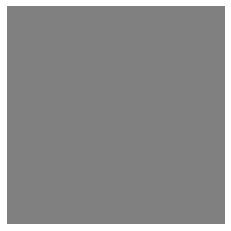

In [13]:
visualizar_imagen(100,x_train)

In [10]:
# Generador
def crear_generador():
    modelo = Sequential()
    modelo.add(Dense(1024*4*4, use_bias=False, input_shape=(TAM_ENTRADA,)))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Reshape((4,4,1024)))
    #4x4x1024

    modelo.add(Conv2DTranspose(512,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #8x8x512

    modelo.add(Conv2DTranspose(256,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #16x16x256

    modelo.add(Conv2DTranspose(128,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #32x32x128

    modelo.add(Conv2DTranspose(64,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #64x64x64

    modelo.add(Conv2DTranspose(3, (5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(Activation('tanh'))
    #128x128x3

    modelo.compile(optimizer=OPTIMIZADOR, loss=ERROR)

    return modelo

In [11]:
generador = crear_generador()

In [12]:
# Discriminador (el inverso del generador)
def crear_discriminador():
    modelo = Sequential()
    modelo.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(128,128,3),
        use_bias=False))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #64x64x64

    modelo.add(Conv2D(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #32x32x128

    modelo.add(Conv2D(256, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #16x16x256

    modelo.add(Conv2D(512, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #8x8x512

    modelo.add(Conv2D(1024, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #4x4x1024

    modelo.add(Flatten())
    modelo.add(Dense(1, activation='sigmoid', use_bias=False))

    modelo.compile(optimizer=OPTIMIZADOR, loss=ERROR)

    return modelo

discriminador = crear_discriminador()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
# GAN

def crear_GAN(generador, discriminador):
    modelo = Sequential()
    modelo.add(generador)
    discriminador.trainable = False
    modelo.add(discriminador)
    modelo.compile(optimizer=OPTIMIZADOR, loss=ERROR)

    return modelo

gan = crear_GAN(generador, discriminador)

In [14]:
# Entrenamiento
#@tf.function
def entrenamiento():
    n_lotes = x_train.shape[0]/TAM_LOTE

    for i in range(1,N_ITS+1):
        print("Epoch " + str(i))

        # Crear un "batch" de imágenes falsas y otro con imágenes reales
        ruido = np.random.normal(0,1,[TAM_LOTE,TAM_ENTRADA])
        batch_falsas = generador.predict(ruido)

        idx = np.random.randint(low=0, high=x_train.shape[0],size=TAM_LOTE)
        batch_reales = x_train[idx]

        # Entrenar discriminador con imagener falsas y reales, y en cada
        # caso calcular el error
        discriminador.trainable = True

        dError_reales = discriminador.train_on_batch(batch_reales,
            np.ones(TAM_LOTE)*0.9)
        dError_falsas = discriminador.train_on_batch(batch_falsas,
            np.zeros(TAM_LOTE)*0.1)

        discriminador.trainable = False

        # Entrenar GAN: se generará ruido aleatorio y se presentará a la GAN
        # como si fuesen imagenes reales
        ruido = np.random.normal(0,1,[TAM_LOTE,TAM_ENTRADA])
        gError = gan.train_on_batch(ruido, np.ones(TAM_LOTE))

        # Graficar ejemplo de imágenes generadas, cada 100 iteraciones
        if i==1 or i%100 == 0:
            graficar_imagenes_generadas(i,generador)
            #generador.save('generador.h5')

entrenamiento()        
generar_imagenes(generador,100)

Epoch 1

Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110
Epoch 1

Epoch 810
Epoch 811
Epoch 812
Epoch 813
Epoch 814
Epoch 815
Epoch 816
Epoch 817
Epoch 818
Epoch 819
Epoch 820
Epoch 821
Epoch 822
Epoch 823
Epoch 824
Epoch 825
Epoch 826
Epoch 827
Epoch 828
Epoch 829
Epoch 830
Epoch 831
Epoch 832
Epoch 833
Epoch 834
Epoch 835
Epoch 836
Epoch 837
Epoch 838
Epoch 839
Epoch 840
Epoch 841
Epoch 842
Epoch 843
Epoch 844
Epoch 845
Epoch 846
Epoch 847
Epoch 848
Epoch 849
Epoch 850
Epoch 851
Epoch 852
Epoch 853
Epoch 854
Epoch 855
Epoch 856
Epoch 857
Epoch 858
Epoch 859
Epoch 860
Epoch 861
Epoch 862
Epoch 863
Epoch 864
Epoch 865
Epoch 866
Epoch 867
Epoch 868
Epoch 869
Epoch 870
Epoch 871
Epoch 872
Epoch 873
Epoch 874
Epoch 875
Epoch 876
Epoch 877
Epoch 878
Epoch 879
Epoch 880
Epoch 881
Epoch 882
Epoch 883
Epoch 884
Epoch 885
Epoch 886
Epoch 887
Epoch 888
Epoch 889
Epoch 890
Epoch 891
Epoch 892
Epoch 893
Epoch 894
Epoch 895
Epoch 896
Epoch 897
Epoch 898
Epoch 899
Epoch 900
Epoch 901
Epoch 902
Epoch 903
Epoch 904
Epoch 905
Epoch 906
Epoch 907
Epoch 908
Epoch 909


Lossy conversion from float32 to uint8. Range [16.392715454101562, 190.43260192871094]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [122.22930908203125, 131.70401000976562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [123.51042175292969, 130.81581115722656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [122.30128479003906, 132.2870330810547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [123.14186096191406, 130.8365478515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [124.36575317382812, 130.2789306640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [123.67981719970703, 130.75344848632812

Lossy conversion from float32 to uint8. Range [122.38874816894531, 131.11280822753906]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [123.4994125366211, 130.65008544921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [121.8520736694336, 131.79612731933594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [122.90218353271484, 130.85122680664062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [123.86559295654297, 130.637939453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 254.99681091308594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [120.92912292480469, 132.95811462402344]. Convert image